<a href="https://colab.research.google.com/github/Jaeljane/Attendance_Prediction/blob/main/Attendance_DecisionTreeClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**Introduction**
Develop a robust predictive model that accurately forecasts the daily attendance of employees for the upcoming week.

####Import the libraries to use

In [6]:
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('/content/drive')


from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#read in the data
data = pd.read_csv('/content/drive/MyDrive/Data Science/Attendance_2.csv')
#create copy to use
df=data.copy()
#size of the dataset
print(df.shape)
#look at the first 5 rows
df.head()

(21912, 12)


,date,day,shift,attendance,Reasons,Employee_Id,Team,Tenure,Month,Week_Numb,Holiday,Holiday_Association
0,12/10/2023,Thursday,Unscheduled,Unscheduled,Other Reasons,A001,T001,>24M,Oct,2,NH,Not_assosiated_with_Holiday
1,12/10/2023,Thursday,Day,Present,Other Reasons,A002,T002,12-24M,Oct,2,NH,Not_assosiated_with_Holiday
2,12/10/2023,Thursday,Day,Present,Other Reasons,A003,T003,>24M,Oct,2,NH,Not_assosiated_with_Holiday
3,12/10/2023,Thursday,Day,Present,Other Reasons,A004,T004,>24M,Oct,2,NH,Not_assosiated_with_Holiday
4,12/10/2023,Thursday,Day,Present,Other Reasons,A005,T005,>24M,Oct,2,NH,Not_assosiated_with_Holiday


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21912 entries, 0 to 21911
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   date                 21912 non-null  object
 1   day                  21911 non-null  object
 2   shift                21912 non-null  object
 3   attendance           21912 non-null  object
 4   Reasons              21912 non-null  object
 5   Employee_Id          21866 non-null  object
 6   Team                 21912 non-null  object
 7   Tenure               21677 non-null  object
 8   Month                21912 non-null  object
 9   Week_Numb            21912 non-null  int64 
 10  Holiday              21912 non-null  object
 11  Holiday_Association  21912 non-null  object
dtypes: int64(1), object(11)
memory usage: 2.0+ MB


In [ ]:
#Change Date Column into Date Time
df['date']=pd.to_datetime(df['date'], format='%d/%m/%Y')
#sort data to be in descending order
df=df.sort_values(by='date')

df.reset_index(drop=True, inplace=True)
df.head()

,date,day,shift,attendance,Reasons,Employee_Id,Team,Tenure,Month,Week_Numb,Holiday,Holiday_Association
0,2023-04-28,Friday,Night,Present,Other Reasons,A170,T002,>24M,Apr,5,NH,Not_assosiated_with_Holiday
1,2023-04-28,Friday,Unscheduled,PTO,Other Reasons,NaN,T005,NaN,Apr,5,NH,Not_assosiated_with_Holiday
2,2023-04-28,Friday,Night,Present,Other Reasons,A104,T011,>24M,Apr,5,NH,Not_assosiated_with_Holiday
3,2023-04-28,Friday,Night,Absent,Sick Leave,A184,T009,>24M,Apr,5,NH,Not_assosiated_with_Holiday
4,2023-04-28,Friday,Night,Present,Other Reasons,A084,T002,>24M,Apr,5,NH,Not_assosiated_with_Holiday


####Import The Weather Data
The Weather Data was obtained from **https://www.visualcrossing.com/**


In [7]:
weather = pd.read_csv('/content/drive/MyDrive/Data Science/Nairobi_Weather.csv')
weather.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,Nairobi,2023-04-28,71.0,61.0,64.8,71.0,61.0,64.8,60.5,86.4,...,22.9,10,10,2023-04-28T06:28:08,2023-04-28T18:32:26,0.25,"Rain, Partially cloudy",Partly cloudy throughout the day with afternoo...,rain,"HKJK,HKNW,63740099999,63742099999"
1,Nairobi,2023-04-29,71.6,59.0,65.3,71.6,59.0,65.3,59.0,81.1,...,17.4,7,10,2023-04-29T06:28:01,2023-04-29T18:32:16,0.30,"Rain, Partially cloudy",Partly cloudy throughout the day with afternoo...,rain,"HKJK,HKNW,63740099999,63742099999"
2,Nairobi,2023-04-30,75.0,62.4,65.7,75.0,62.4,65.7,60.6,84.6,...,15.1,8,10,2023-04-30T06:27:55,2023-04-30T18:32:06,0.33,Overcast,Cloudy skies throughout the day.,cloudy,"HKJK,HKNW,63740099999,63742099999"
3,Nairobi,2023-05-01,71.4,62.4,65.5,71.4,62.4,65.5,60.3,83.8,...,10.0,6,10,2023-05-01T06:27:49,2023-05-01T18:31:57,0.36,"Rain, Partially cloudy",Partly cloudy throughout the day with early mo...,rain,"HKJK,HKNW,63740099999,63742099999"
4,Nairobi,2023-05-02,75.2,59.6,65.7,75.2,59.6,65.7,59.3,81.3,...,16.7,8,10,2023-05-02T06:27:43,2023-05-02T18:31:49,0.39,"Rain, Partially cloudy",Partly cloudy throughout the day with late aft...,rain,"HKJK,remote,HKNW,63740099999,63742099999"


In [10]:
weather['datetime']=pd.to_datetime(weather['datetime'])
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   name              187 non-null    object        
 1   datetime          187 non-null    datetime64[ns]
 2   tempmax           187 non-null    float64       
 3   tempmin           187 non-null    float64       
 4   temp              187 non-null    float64       
 5   feelslikemax      187 non-null    float64       
 6   feelslikemin      187 non-null    float64       
 7   feelslike         187 non-null    float64       
 8   dew               187 non-null    float64       
 9   humidity          187 non-null    float64       
 10  precip            187 non-null    float64       
 11  precipprob        187 non-null    float64       
 12  precipcover       187 non-null    float64       
 13  preciptype        145 non-null    object        
 14  snow              187 non-

In [11]:
weather.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,Nairobi,2023-04-28,71.0,61.0,64.8,71.0,61.0,64.8,60.5,86.4,...,22.9,10,10,2023-04-28T06:28:08,2023-04-28T18:32:26,0.25,"Rain, Partially cloudy",Partly cloudy throughout the day with afternoo...,rain,"HKJK,HKNW,63740099999,63742099999"
1,Nairobi,2023-04-29,71.6,59.0,65.3,71.6,59.0,65.3,59.0,81.1,...,17.4,7,10,2023-04-29T06:28:01,2023-04-29T18:32:16,0.30,"Rain, Partially cloudy",Partly cloudy throughout the day with afternoo...,rain,"HKJK,HKNW,63740099999,63742099999"
2,Nairobi,2023-04-30,75.0,62.4,65.7,75.0,62.4,65.7,60.6,84.6,...,15.1,8,10,2023-04-30T06:27:55,2023-04-30T18:32:06,0.33,Overcast,Cloudy skies throughout the day.,cloudy,"HKJK,HKNW,63740099999,63742099999"
3,Nairobi,2023-05-01,71.4,62.4,65.5,71.4,62.4,65.5,60.3,83.8,...,10.0,6,10,2023-05-01T06:27:49,2023-05-01T18:31:57,0.36,"Rain, Partially cloudy",Partly cloudy throughout the day with early mo...,rain,"HKJK,HKNW,63740099999,63742099999"
4,Nairobi,2023-05-02,75.2,59.6,65.7,75.2,59.6,65.7,59.3,81.3,...,16.7,8,10,2023-05-02T06:27:43,2023-05-02T18:31:49,0.39,"Rain, Partially cloudy",Partly cloudy throughout the day with late aft...,rain,"HKJK,remote,HKNW,63740099999,63742099999"


###**EDA**

In [ ]:
df['attendance'].value_counts()

Present        19742
PTO             1322
Absent           760
Unscheduled       88
Name: attendance, dtype: int64

We are only interested in Employees who were Present and those who were absent and not those who were on leave cause in this case PTO and Unscheduled implies that the employee was on planned leave hence we would have to remove these records before doing any further analysis

In [ ]:
# retain=["Present", "Absent"]

#  # df=df[df['attendance'].isin(i)]
# df = df[df['attendance'].isin(retain)]


In [ ]:
#Check for null values
df.isnull().sum()

date                     0
day                      1
shift                    0
attendance               0
Reasons                  0
Employee_Id             46
Team                     0
Tenure                 235
Month                    0
Week_Numb                0
Holiday                  0
Holiday_Association      0
dtype: int64

In [ ]:
#check those employees missing Employee ID

a=df[df['Employee_Id'].isnull()]
a.head()

,date,day,shift,attendance,Reasons,Employee_Id,Team,Tenure,Month,Week_Numb,Holiday,Holiday_Association
1,2023-04-28,Friday,Unscheduled,PTO,Other Reasons,NaN,T005,NaN,Apr,5,NH,Not_assosiated_with_Holiday
77,2023-04-28,Friday,Night,Absent,Unplanned Leave,NaN,T007,NaN,Apr,5,NH,Not_assosiated_with_Holiday
80,2023-04-28,Friday,Night,Absent,Unplanned Leave,NaN,T009,NaN,Apr,5,NH,Not_assosiated_with_Holiday
88,2023-04-28,Friday,Night,Present,Other Reasons,NaN,T012,NaN,Apr,5,NH,Not_assosiated_with_Holiday
127,2023-04-28,Friday,Unscheduled,Unscheduled,Unplanned Leave,NaN,T001,NaN,Apr,5,NH,Not_assosiated_with_Holiday


Since we are trying to predict individual employee attendance, it will not be useful having records that miss employee ID hence we would have to drop these records.

In [ ]:
df = df[~df['Employee_Id'].isnull()]

In [ ]:
df['shift'].replace('Unscheduled', "Day", inplace =True)

<ipython-input-11-7294811b14f3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['shift'].replace('Unscheduled', "Day", inplace =True)


In [ ]:
df_a=df[df['attendance']=="Absent"]
df_a.shape

(745, 12)

<Axes: title={'center': 'Reasons for Absenteeism'}>

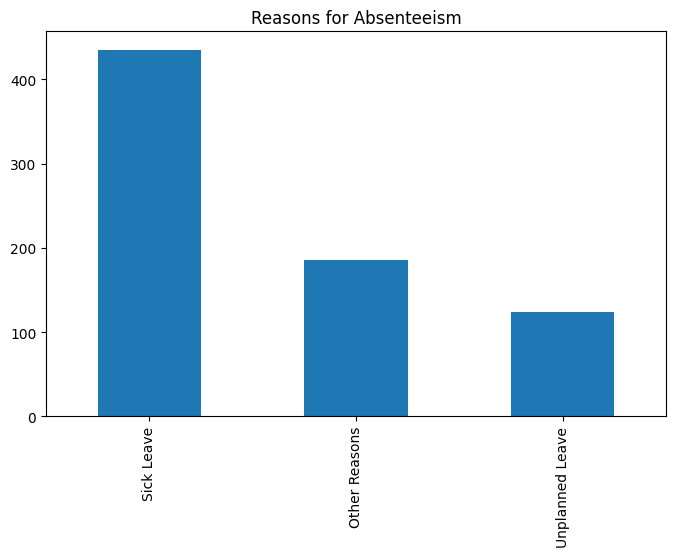

In [ ]:
df_a['Reasons'].value_counts().plot(figsize=(8,5),kind="bar", title="Reasons for Absenteeism")

Sick leaves are the most common reason for absenteeism within employees


In [ ]:
def proportions(x):
  a=df_a[x].value_counts()
  b=df[x].value_counts()
  c= a.index.union(b.index)

  value_counts_df = b.reindex(c, fill_value=0)
  value_counts_df_a = a.reindex(c, fill_value=0)
  proportions=value_counts_df_a/value_counts_df


  return proportions

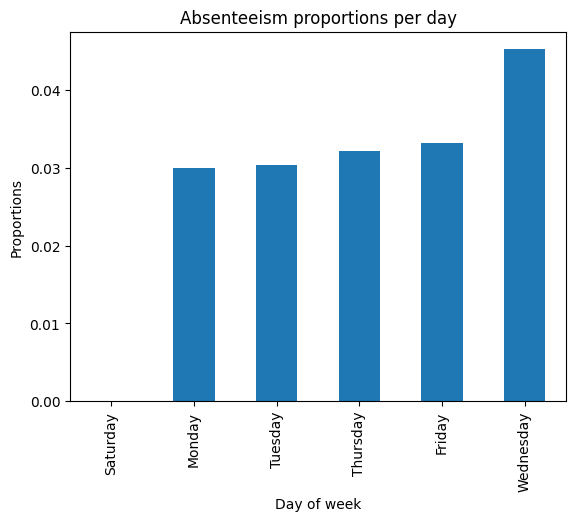

In [ ]:
day=proportions('day')
day.sort_values().plot(kind="bar",title= "Absenteeism proportions per day", xlabel="Day of week", ylabel="Proportions");

Saturday is not a working day and if anywork is done on this particular day it is considered Overtime work and should be voluntary.
Wednesday on the other hand has the highest rate of absenteeism

In [ ]:
i=df_a[df_a['shift']=="Unscheduled"]
i

,date,day,shift,attendance,Reasons,Employee_Id,Team,Tenure,Month,Week_Numb,Holiday,Holiday_Association


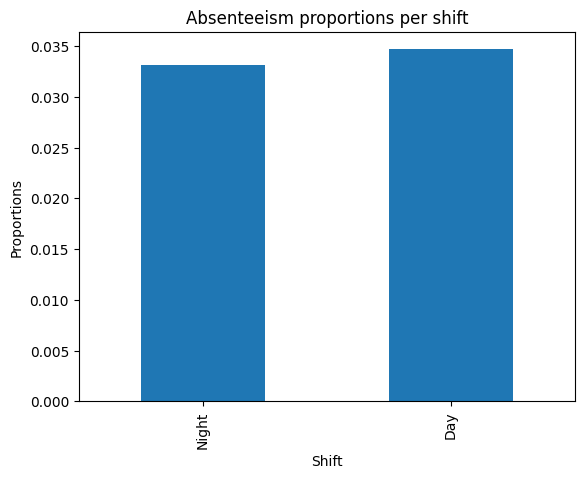

In [ ]:
shift=proportions('shift')
shift.sort_values().plot(kind="bar",title= "Absenteeism proportions per shift", xlabel="Shift", ylabel="Proportions");

The day shift has the highest proportion of absenteeism

In [ ]:
team=proportions("Team").sort_values()
Tenure=proportions('Tenure').sort_values()
Month=proportions("Month")
Week_Numb=proportions("Week_Numb").sort_values()

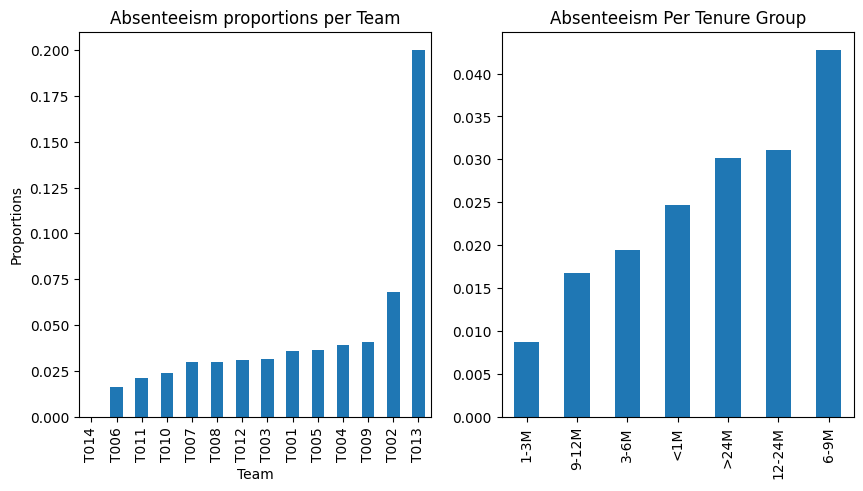

<Figure size 1000x500 with 0 Axes>

In [ ]:
# Create a figure and a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2)
plt.figure(figsize=[10, 5])

# Plot data from the DataFrame on the subplots

team.plot(figsize=[10, 5],kind="bar", xlabel="Team", ylabel="Proportions", ax=axs[0])
axs[0].set_title("Absenteeism proportions per Team")

Tenure.plot(figsize=[10, 5], kind="bar" ,ax=axs[1])
axs[1].set_title("Absenteeism Per Tenure Group")

# Show the figure
plt.show();


Team T013 has the highest rate of absenteeism and this should be looked into also employees with a tenure of between 6-9 months have a higher rate of absenteeism

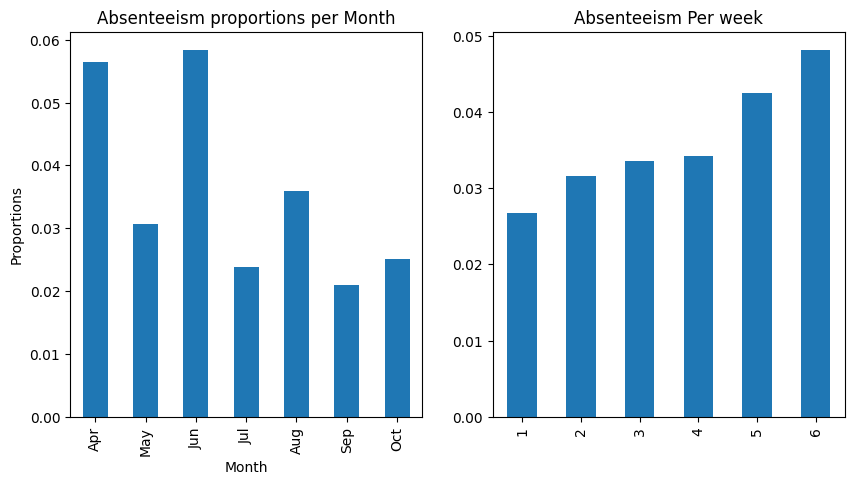

<Figure size 1000x500 with 0 Axes>

In [ ]:
# Create a figure and a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2)
plt.figure(figsize=[10, 5])

# Plot data from the DataFrame on the subplots
# Generate the x-ticks for the graph
ticks = ["Apr", 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct']
# Convert ticks into string values and to be displayed on the X axis
#labels = ['{}'.format(v) for v in ticks]
Month.plot(figsize=[10, 5],kind="bar", xlabel="Month", ylabel="Proportions", ax=axs[0])
axs[0].set_xticklabels(ticks)
axs[0].set_title("Absenteeism proportions per Month")

tick = ["1", "2", "3", "4", "5", "6"]
Week_Numb.plot(figsize=[10, 5], kind="bar" ,ax=axs[1])
axs[1].set_title("Absenteeism Per week")
axs[1].set_xticklabels(tick)
# Show the figure
plt.show();

Within the month Absenteeism increases as the month progresses. Also note that week happens when date 31st fall on a monday. This happened in July.


###**Remove outliers**

In [ ]:
df['day'].value_counts()

Friday       4425
Thursday     4379
Monday       4364
Wednesday    4355
Tuesday      4241
Saturday      101
Name: day, dtype: int64

In [ ]:
#Remove Saturdays data because attendance is voluntary and considered over time work
df=df[df['day']!="Saturday"]

In [ ]:
#remove holidays also because working on a holiday is considered overtime and it is voluntary
df['Holiday'].value_counts()

NH    21415
H       350
Name: Holiday, dtype: int64

In [ ]:
df=df[df['Holiday']!="H"]
df.head()

,date,day,shift,attendance,Reasons,Employee_Id,Team,Tenure,Month,Week_Numb,Holiday,Holiday_Association
0,2023-04-28,Friday,Night,Present,Other Reasons,A170,T002,>24M,Apr,5,NH,Not_assosiated_with_Holiday
2,2023-04-28,Friday,Night,Present,Other Reasons,A104,T011,>24M,Apr,5,NH,Not_assosiated_with_Holiday
3,2023-04-28,Friday,Night,Absent,Sick Leave,A184,T009,>24M,Apr,5,NH,Not_assosiated_with_Holiday
4,2023-04-28,Friday,Night,Present,Other Reasons,A084,T002,>24M,Apr,5,NH,Not_assosiated_with_Holiday
5,2023-04-28,Friday,Night,Present,Other Reasons,A151,T003,>24M,Apr,5,NH,Not_assosiated_with_Holiday


In [ ]:
#Drop unnecessary columns
#Drop Reasons because it is directly associated with attendance, drop Holiday cause it has only one variable
df.drop(columns=['Reasons', 'Holiday'], inplace=True)

In [ ]:
#set date as index
df.set_index("date", inplace=True)
df.head()

,day,shift,attendance,Employee_Id,Team,Tenure,Month,Week_Numb,Holiday_Association
date,,,,,,,,,
2023-04-28,Friday,Night,Present,A170,T002,>24M,Apr,5,Not_assosiated_with_Holiday
2023-04-28,Friday,Night,Present,A104,T011,>24M,Apr,5,Not_assosiated_with_Holiday
2023-04-28,Friday,Night,Absent,A184,T009,>24M,Apr,5,Not_assosiated_with_Holiday
2023-04-28,Friday,Night,Present,A084,T002,>24M,Apr,5,Not_assosiated_with_Holiday
2023-04-28,Friday,Night,Present,A151,T003,>24M,Apr,5,Not_assosiated_with_Holiday


In [ ]:
df['attendance'].value_counts()

Present        19272
PTO             1319
Absent           745
Unscheduled       79
Name: attendance, dtype: int64

In [ ]:
#encode the target variable
df["attendance"] = df["attendance"].apply(lambda x: "Present" if x == "Present" else "Absent")

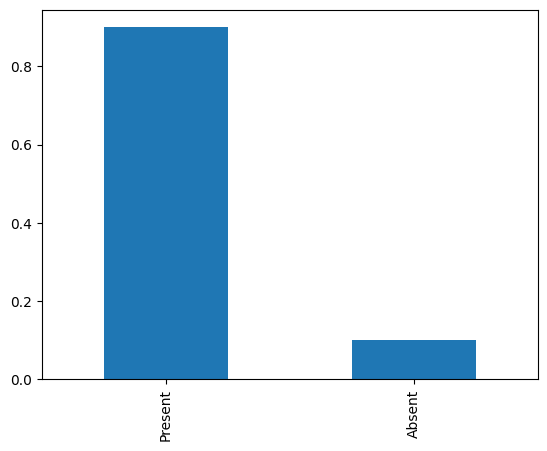

In [ ]:
df['attendance'].value_counts(normalize=True).plot(kind="bar");

That's good news for the company! Since absenteeism is quite low. However, it also shows us that we have an imbalanced dataset, where our majority class(Present) is far bigger than our minority class(Absent).

###**Split the Dataset**

In [ ]:
target="attendance"
X=df.drop(columns=['attendance'])
y=df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (21415, 8)
y shape: (21415,)


In [ ]:
# cutoff = 17483
# X_train, y_train =X.iloc[:cutoff], y.iloc[:cutoff]
# X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train:", X_train.shape )
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test", y_test.shape)

X_train: (17132, 8)
y_train: (17132,)
X_test: (4283, 8)
y_test (4283,)


In [ ]:
X_train.head()

,day,shift,Employee_Id,Team,Tenure,Month,Week_Numb,Holiday_Association
date,,,,,,,,
2023-08-22,Tuesday,Night,A135,T004,>24M,Aug,4,Not_assosiated_with_Holiday
2023-06-14,Wednesday,Night,A123,T006,>24M,Jun,3,Not_assosiated_with_Holiday
2023-08-25,Friday,Night,A114,T008,12-24M,Aug,4,Not_assosiated_with_Holiday
2023-09-08,Friday,Night,A034,T008,12-24M,Sep,2,Not_assosiated_with_Holiday
2023-04-28,Friday,Night,A171,T003,>24M,Apr,5,Not_assosiated_with_Holiday


###**Resample**

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
over_sampler = RandomOverSampler()
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print(X_train_over.shape)
X_train_over.head()

(30832, 8)


,day,shift,Employee_Id,Team,Tenure,Month,Week_Numb,Holiday_Association
0,Tuesday,Night,A135,T004,>24M,Aug,4,Not_assosiated_with_Holiday
1,Wednesday,Night,A123,T006,>24M,Jun,3,Not_assosiated_with_Holiday
2,Friday,Night,A114,T008,12-24M,Aug,4,Not_assosiated_with_Holiday
3,Friday,Night,A034,T008,12-24M,Sep,2,Not_assosiated_with_Holiday
4,Friday,Night,A171,T003,>24M,Apr,5,Not_assosiated_with_Holiday


In [ ]:
y_train_over.value_counts()

Present    15416
Absent     15416
Name: attendance, dtype: int64

###**Build Model**

####Set the baseline accuracy Score

In [ ]:
base_acc=y_train.value_counts(normalize=True).max()
print("Baseline Accuracy Score:", base_acc )

Baseline Accuracy Score: 0.8998365631566659


Our Model should try to beat this score

In [ ]:
# !pip install --upgrade pip
# !pip install --upgrade setuptools


####Make pipeline and Build the Model

In [ ]:
!pip install category_encoders

from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 2.5 MB/s eta 0:00:00


In [ ]:
clf= make_pipeline(SimpleImputer(strategy='most_frequent'),
                      OneHotEncoder(use_cat_names=True),
                      DecisionTreeClassifier())
#clf.fit(X_train_over, y_train_over)

In [ ]:
params = {
    "decisiontreeclassifier__criterion": ['gini', 'entropy'],
    "decisiontreeclassifier__max_depth": range(20, 100, 10),
    "decisiontreeclassifier__min_samples_split": range(2, 10),  # Changed from 1 to 2
    "decisiontreeclassifier__min_samples_leaf": range(1, 5)  # Corrected the parameter name
}
params

{'decisiontreeclassifier__criterion': ['gini', 'entropy'],
 'decisiontreeclassifier__max_depth': range(20, 100, 10),
 'decisiontreeclassifier__min_samples_split': range(2, 10),
 'decisiontreeclassifier__min_samples_leaf': range(1, 5)}

In [ ]:
from sklearn.model_selection import GridSearchCV
model = GridSearchCV(clf, param_grid=params, cv=5, n_jobs=-1,verbose=1)

In [ ]:
# model= make_pipeline(SimpleImputer(strategy='most_frequent'),
#                       OneHotEncoder(use_cat_names=True),
#                      DecisionTreeClassifier())
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 512 candidates, totalling 2560 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='most_frequent')),
                                       ('onehotencoder',
                                        OneHotEncoder(use_cat_names=True)),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__criterion': ['gini',
                                                               'entropy'],
                         'decisiontreeclassifier__max_depth': range(20, 100, 10),
                         'decisiontreeclassifier__min_samples_leaf': range(1, 5),
                         'decisiontreeclassifier__min_samples_split': range(2, 10)},
             verbose=1)

In [ ]:
acc_train=model.score(X_train_over, y_train_over)
acc_test=model.score(X_test, y_test)

print("Accuracy Train Score", round(acc_train, 4))
print("Accuracy Test Score", round(acc_test, 4))

Accuracy Train Score 1.0
Accuracy Test Score 0.9237


Accuracy scores can be misleading when dealing with imbalanced data, because the model may simply be predicting the majority class most of the time. Instead of looking at overall accuracy, we should look at how well the model predicts each class individually. This is because we may be more concerned with the model's performance on the minority class, even if the overall accuracy is high.

####Confusion matrix


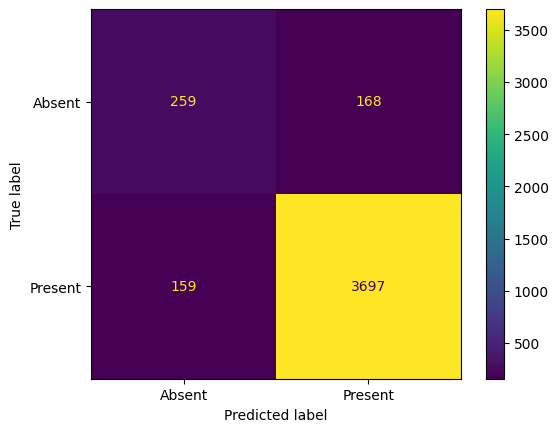

In [ ]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);

In [ ]:
depth = model.named_steps['decisiontreeclassifier'].get_depth()
print(depth)

AttributeError: ignored

In [ ]:
model.best_params_

{'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 90,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2}

###**Recall and Precision**
Precision is important when we want to make sure our model only predicts absences when it is very confident in its prediction. Recall is important when we want to make sure we identify all absences, even if it means making some mistakes.

In [ ]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

      Absent       0.62      0.61      0.61       427
     Present       0.96      0.96      0.96      3856

    accuracy                           0.92      4283
   macro avg       0.79      0.78      0.79      4283
weighted avg       0.92      0.92      0.92      4283



Recall Score measures how well a model identifies observations that belong to the positive class.
Precision measures how well the model identifies observations that belong to the positive class without making an error of a false positive. (Make a careful decision)


###Save Model

In [ ]:
import pickle

In [ ]:
#save model
with open("model.pkl", "wb") as f:
  pickle.dump(model, f)

In [ ]:
def wrangle(data_path):
  test=pd.read_csv(data_path)

  test=test[~test['Employee_Id'].isnull()]
  test['Week_Numb'] = test['Week_Numb'].astype('object')
  test=test[test['Holiday']!="H"]
  test['shift'].replace('Unscheduled', "Day", inplace =True)
  test.drop(columns=['Reasons', "Holiday"], inplace=True)
  test.set_index("date", inplace=True)
  test=test.drop(columns=['attendance'])

  return test


In [ ]:
def make_predictions(data_filepath, model_filepath):
    # Read in the data
    test = wrangle(data_filepath)
    # Load model
    with open (model_filepath, "rb") as f:
        model=pickle.load(f)
    # Generate predictions
    y_test_pred = model.predict(test)
    # Put predictions into Series with name "Absent", and same index as X_test
    y_test_pred = pd.Series(y_test_pred, index=test.index, name="Absent")
    return y_test_pred

In [ ]:
test=wrangle('/content/drive/MyDrive/Data Science/X_test.csv')
print(test.shape)
test.head()

NameError: ignored

In [ ]:
y_test_pred = make_predictions(
    data_filepath="/content/drive/MyDrive/Data Science/X_test.csv",
    model_filepath="/content/model.pkl",
)

print("predictions shape:", y_test_pred.shape)
y_test_pred.head()

predictions shape: (934,)


date
19/10/2023    1
19/10/2023    1
19/10/2023    1
19/10/2023    1
19/10/2023    1
Name: Absent, dtype: int64

In [ ]:
y_test_pred.to_csv('absenteeism_pred.csv', index=True)

In [ ]:
# features = X_train_over.columns
# importances = model.named_steps['decisiontreeclassifier'].feature_importances_

# feat_imp= pd.Series(importances, index=features).sort_values()
# feat_imp.head()

In [ ]:
# # Access the OneHotEncoder from the pipeline
# one_hot_encoder = model.named_steps['onehotencoder']

# # Get the transformed feature names from the OneHotEncoder
# feature_names = one_hot_encoder.get_feature_names_out()

# # Create a list of tuples with feature names and their corresponding importances
# importance_feature_pairs = list(zip(feature_names, feature_importances))

# # Sort the list by feature importances in descending order
# importance_feature_pairs.sort(key=lambda x: x[1], reverse=True)

# # Create a pandas Series directly from the sorted list
# feat_imp = pd.Series([pair[1] for pair in importance_feature_pairs], index=[pair[0] for pair in importance_feature_pairs])

# # Create a bar plot for the top 15 features
# top_n = 15
# feat_imp.head(top_n).plot(kind='barh', figsize=(10, 8))
# plt.xlabel('Gini Importance')
# plt.ylabel('Feature')
# plt.title('Top {} Feature Importance'.format(top_n))
# plt.show()
